# Free final time rendez-vous in CR3BP

Let $\boldsymbol{x} = [x,y,z,v_x,v_y,v_z,\log{m}]$ denote the spacecraft state, with control $\boldsymbol{u} = [a_x,a_y,a_z]$.

We consider the CR3BP dynamics,

$$
\dot{\boldsymbol{x}} = \boldsymbol{f}(\boldsymbol{x},\boldsymbol{u},t) = 
\begin{bmatrix}
    \boldsymbol{v} \\
    -\dfrac{1-\mu}{r_1^3}\boldsymbol{r}_1 - \dfrac{\mu}{r_2^3}\boldsymbol{r}_2 - \boldsymbol{\omega} \times (\boldsymbol{\omega} \times \boldsymbol{r}) - 2\boldsymbol{\omega} \times \boldsymbol{r}
    \\
    0
\end{bmatrix}
+
\begin{bmatrix}
    B & 0_{6 \times 1} \\
    0_{1\times 3} & -1/c_{\rm ex}
\end{bmatrix}
\begin{bmatrix}
    \boldsymbol{u} \\ \Gamma
\end{bmatrix}
$$

where $\boldsymbol{\omega} = [0,0,1]$, $c_{\rm ex} = I_{\rm sp} g_0$ is the exhaust velocity of the engine, $B=\mathrm{vcat}(0_{3\times3}, \boldsymbol{I}_3)$, and $\Gamma = \| \boldsymbol{u} \|_2$. 

The minimum-fuel OCP is given by

$$
\begin{aligned}
\min_{\boldsymbol{x}(t),\boldsymbol{u}(t),t_f} \quad& -m(t_f)
\\\text{s.t.}\quad&
\dot{\boldsymbol{x}} = \boldsymbol{f}(\boldsymbol{x},\boldsymbol{u},t)
\\&
\| \boldsymbol{u}(t) \|_2 \leq \dfrac{T_{\max}}{m(t)}
\\&
\boldsymbol{x}(t_0) = [\boldsymbol{r},\boldsymbol{v},m]_{\rm init}
\\&
\boldsymbol{x}_{[0:6]}(t_f) = [\boldsymbol{r},\boldsymbol{v}]_{\rm final}
\\&
\end{aligned}
$$

where $\boldsymbol{x}_{\rm final}$ and $\boldsymbol{x}_{\rm final}$ are the (given) initial and final conditions; note that for the final conditions, we do *not* fix the final mass $m$.

To formulate first a non-convex, discretized NLP of the variable time OCP, let $t$ (i.e. the physical time) be a strictly increasing, smooth function of a new dilated time variable $\tau \in [0,1]$, such that $t(\tau = 0) = t_0$ and $t(\tau = 1) = t_f$.
Let the derivative of $\tau$, i.e. the "dilation factor" be denoted by $s(\tau)$.
Then, we consider an augmented dynamical system, with augmented state $\tilde{\boldsymbol{x}} = [\boldsymbol{x}, t]$ and augmented control $\tilde{\boldsymbol{u}} = [\boldsymbol{u},s,\Gamma]$ where $\Gamma = \sqrt{a_x^2 + a_y^2 + a_z^2}$, with corresponding dynamics given by

$$
{\tilde{\boldsymbol{x}}}^{\prime} = \tilde{\boldsymbol{f}}(\boldsymbol{x},\tilde{\boldsymbol{u}},t) = 
s
\begin{bmatrix}
    \boldsymbol{v} \\
    -\dfrac{1-\mu}{r_1^3}\boldsymbol{r}_1 - \dfrac{\mu}{r_2^3}\boldsymbol{r}_2 - \boldsymbol{\omega} \times (\boldsymbol{\omega} \times \boldsymbol{r}) - 2\boldsymbol{\omega} \times \boldsymbol{r}
    \\
    0
    \\
    0
\end{bmatrix}
+
\begin{bmatrix}
    s B\boldsymbol{u} & 0_{6 \times 1} & 0_{6 \times 1} \\
    0_{1\times 3} & 0 & -s/c_{\rm ex} \\
    0_{1\times 3} & 1 & 0
\end{bmatrix}
\begin{bmatrix}
    \boldsymbol{u} \\ s \\ \Gamma
\end{bmatrix}
$$

Note that the dynamics is no longer affine, since both $s$ and $\boldsymbol{u}$ are control variables.

Through discretization into $N$ nodes (so $N-1$ control segments) assuming zeroth-order hold of the controls and (2) , we get the following non-convex NLP

$$
\begin{aligned}
\min_{\boldsymbol{x},\boldsymbol{u},t_f} \quad& -m_{N-1}
\\\text{s.t.}\quad&
\boldsymbol{x}_{k+1} = \boldsymbol{x}_k + \int_{t_k}^{t_k+1} \boldsymbol{f}(\boldsymbol{x}, \boldsymbol{u}, t) \mathrm{d}t
    \quad \forall k = 0,\ldots,N-2
\\&
\| \boldsymbol{u}_k \|_2 \leq \dfrac{T_{\max}}{m_k}
    \quad \forall k = 0,\ldots,N-2
\\&
\boldsymbol{x}_0 = [\boldsymbol{r},\boldsymbol{v},m]_{\rm init}
\\&
\boldsymbol{x}_{N-1} = [\boldsymbol{r},\boldsymbol{v}]_{\rm final}
\\&
\end{aligned}
$$

where $(\cdot)_k$ denote the quantity at the $k^{\rm th}$ node.

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.append("..")

import scocp

We first define the integrators. We will construct one in the time-domain to propagate our initial guess etc., and one in the $\tau \in [0,1]$ domain to be used inside the OCP.

We use the equations of motions that are already implemented inside `scocp`. 
The time-domain integrator is just the EOMs of the CR3BP.

Specifically for the $\tau$-domain integrator, let's still look at them to get a better idea of what's been implemented:

```python
def control_rhs_cr3bp_logmass_freetf(tau, state, parameters, u):
    """Equation of motion in CR3BP with continuous control in the rotating frame
    state = [x,y,z,vx,vy,vz,log(mass),t]
    u = [ax, ay, az, s, Gamma] where s is the dilation factor, Gamma is the control magnitude (at convergence)
    """
    # unpack parameters
    mu, cex = parameters
    # derivative of state
    deriv = np.zeros(8,)
    B = np.concatenate((np.zeros((3,3)), np.eye(3)))
    deriv[0:6] = u[3] * (scocp.rhs_cr3bp(state[6], state[0:6], mu) + B @ u[0:3])
    deriv[6]   = u[3] * u[4] * (-1/cex)     # control on log(mass), multiplied by time-dilation factor
    deriv[7]   = u[3]                       # control on t(tau)
    return deriv
```

Let's now look at the equations of motion that propagates both the state and the STM's `Phi_A`, `Phi_B`, and `Phi_c` for the linearized model.
Specifically, the following EOM propagates the extended state $\tilde{\boldsymbol{x}}_{\rm ext}$, given by

$$
\tilde{\boldsymbol{x}}_{\rm ext} = \operatorname{vec}\left(\tilde{\boldsymbol{x}}, \boldsymbol{\Phi}_A, \boldsymbol{\Phi}_B \right)
$$

then, after solving the IVP, $\Phi_c$ from $t_k$ to $t_{k+1}$ is constructed as

$$
\Phi_c = \tilde{\boldsymbol{x}}_{k+1} - \Phi_A \tilde{\boldsymbol{x}}_k - \Phi_B \tilde{\boldsymbol{u}}_k
$$

```python
def control_rhs_cr3bp_logmass_freetf_stm(tau, state, parameters, u):
    """Equation of motion in CR3BP with continuous control in the rotating frame with STM
    state = [x,y,z,vx,vy,vz,log(mass),t] + STM.flatten()
    u = [ax, ay, az, s, Gamma] where s is the dilation factor, Gamma is the control magnitude (at convergence)
    """
    # derivative of state
    mu, cex = parameters
    deriv = np.zeros(112)    # 8 + 8*8 + 8*5
    deriv[0:8] = control_rhs_cr3bp_logmass_freetf(tau, state[0:8], parameters, u)
    
    # derivative of STM
    Phi_A = state[8:72].reshape(8,8)
    A = np.zeros((8,8))
    A[0:3,3:6] = np.eye(3)
    A[3,4] = 2
    A[4,3] = -2
    A[3:6,0:3] = scocp.gravity_gradient_cr3bp(state[0:3], mu)
    deriv[8:72] = np.dot(u[3] * A, Phi_A).reshape(64,)

    # derivative of control sensitivity
    B = np.zeros((8,5))
    B[3:6,0:3] = u[3] * np.eye(3)
    B[0:8,3] = control_rhs_cr3bp_logmass_freetf(tau, state[0:8], parameters, u)/u[3]
    B[6,4] = -u[3]/cex
    Phi_B = state[72:112].reshape(8,5)
    deriv[72:112] = (np.dot(u[3] * A, Phi_B) + B).reshape(40,)
    return deriv
```

The `control_rhs_cr3bp_logmass_freetf_stm()` allows us to construct `Phi_A`, `Phi_B`, and `Phi_c`, as is done inside the `scocp.ContinuousControlSCOCP.build_linear_model()` method. 

Now that we know what the equations of motion look like, let's first construct our scipy integrators.

In [2]:
# ODE parameters
mu = 1.215058560962404e-02
cex = 0.8       # exhaust velocity
parameters_ode = (mu, cex)

# we create the time-domain integrator for plotting etc.
integrator_timedomain = scocp.ScipyIntegrator(
    nx=7,
    nu=3,
    rhs=scocp.control_rhs_cr3bp_logmass,
    rhs_stm=scocp.control_rhs_cr3bp_logmass_stm,
    args=(parameters_ode,[0.0,0.0,0.0,0.0]),
    method='DOP853',
    reltol=1e-12,
    abstol=1e-12
)

# this is the non-dimentional time integrator for solving the OCP
integrator_01domain = scocp.ScipyIntegrator(
    nx=8,
    nu=4,
    n_gamma=1,
    rhs=scocp.control_rhs_cr3bp_logmass_freetf,
    rhs_stm=scocp.control_rhs_cr3bp_logmass_freetf_stm,
    impulsive=False,
    args=(parameters_ode,[0.0,0.0,0.0,1.0,0.0]),
    method='DOP853', reltol=1e-12, abstol=1e-12)

We now define our initial and final conditions $\boldsymbol{x}_{\rm init}$ and $\boldsymbol{x}_{\rm final}$. 
We also propagate these in the time-domain to later construct an initial guess.

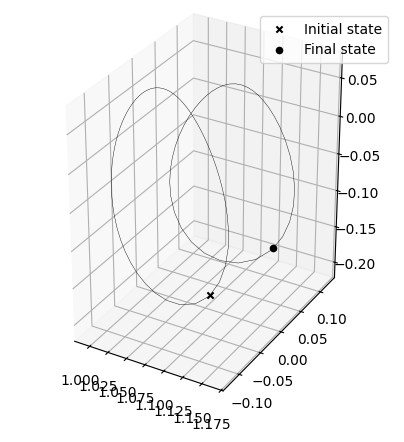

In [3]:
# propagate uncontrolled and controlled dynamics
x0 = np.array([
    1.0809931218390707E+00,
    0.0,
    -2.0235953267405354E-01,
    0.0,
    -1.9895001215078018E-01,
    0.0,
    np.log(1.0),                        # initial log-mass (fixed)
])
period_0 = 2.3538670417546639E+00
sol_lpo0 = integrator_timedomain.solve([0, period_0], x0, get_ODESolution=True)

xf = np.array([
    1.1648780946517576,
    0.0,
    -1.1145303634437023E-1,
    0.0,
    -2.0191923237095796E-1,
    0.0,
    np.log(0.5),                        # final log-mass (guess)
])
period_f = 3.3031221822879884
sol_lpo1 = integrator_timedomain.solve([0, period_f], xf, get_ODESolution=True)

# quick check of what these look like
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(x0[0], x0[1], x0[2], marker='x', color='k', label='Initial state')
ax.scatter(xf[0], xf[1], xf[2], marker='o', color='k', label='Final state')
ax.plot(sol_lpo0.y[0,:], sol_lpo0.y[1,:], sol_lpo0.y[2,:], 'k-', lw=0.3)
ax.plot(sol_lpo1.y[0,:], sol_lpo1.y[1,:], sol_lpo1.y[2,:], 'k-', lw=0.3)
ax.set_aspect('equal')
ax.legend()
plt.show()


Let's now define the discretization grid.
We will use $N = 40$ (i.e. 40 nodes), and set our initial guess time of flight (i.e. final time, since WLOG we assume initial time to be $0$) to the period of the final LPO.

In [4]:
# transfer problem discretization
N = 40
tf_bounds = np.array([period_0, 1.3 * period_f])
tf_guess = period_f
s_bounds = [0.01*tf_guess, 10*tf_guess]

times_guess = np.linspace(0, tf_guess, N)    # initial guess
taus = np.linspace(0, 1, N)

We now construct an initial guess; let's start with the augmented states $\tilde{\boldsymbol{x}}_k$.

Let's propagate the initial and final states over the course of the initial guess times, and linearly interpolate between the two.

Since we want our final solution to start at `x0` and end at `xf` (excluding the final mass), we will enforce our initial guess state `xbar[0,0:7]` and `xbar[-1,0:7]` to `x0` and `xf`, respectively.
We assume a uniform time dilation as initial guess, so `xbar[:,7] = np.linspace(0, tf_guess, N)`. 

Note that the way we are constructing the initial guess is arguably arbitrary; if you have a way to construct a better initial guess, you can use that instead:)

In [5]:
# create initial guess for states
sol_initial = integrator_timedomain.solve([0, times_guess[-1]], x0, t_eval=times_guess, get_ODESolution=True)
sol_final  = integrator_timedomain.solve([0, times_guess[-1]], xf, t_eval=times_guess, get_ODESolution=True)

alphas = np.linspace(1,0,N)
xbar = (np.multiply(sol_initial.y, np.tile(alphas, (7,1))) + np.multiply(sol_final.y, np.tile(1-alphas, (7,1)))).T
xbar[:,6]   = np.log(np.linspace(1.0, 0.5, N))  # initial guess for log-mass
xbar[0,0:7]   = x0                 # overwrite initial state
xbar[-1,0:7]  = xf                 # overwrite final state
xbar = np.concatenate((xbar,  times_guess.reshape(-1,1)), axis=1)    # append initial guess for time

We now construct an initial guess for the controls $\tilde{\boldsymbol{u}}_ = [\boldsymbol{u}_k, s_k, \Gamma_k]$.
- For the acceleration, we will make use of the states we just generated to get the required acceleration assuming no external forces by dividing the difference in velocity between nodes at $t_{k}$ and $t_{k+1}$ by $t_{k+1} - t_k$.
- For the dilation factor $s$, we assume an uniform initial guess, so simply $s = t_{f,\mathrm{guess}}$.
- For $\Gamma$, we simply use the magnitude of $\boldsymbol{u}$.

In [6]:
# create initial guess for controls
sbar_initial = tf_guess * np.ones((N-1,1))
ubar = np.concatenate((np.divide(np.diff(xbar[:,3:6], axis=0), np.diff(times_guess)[:,None]), sbar_initial), axis=1)
gbar = np.sum(ubar[:,0:3], axis=1).reshape(-1,1)    # norms of acceleration controls

Let's now construct the RDV problem. We will use the `scocp.FreeTimeContinuousRendezvousLogMass` class. 
For the sake of clarity, let's see what that looks like:

```python
class FreeTimeContinuousRendezvousLogMass(ContinuousControlSCOCP):
    """Free-time continuous rendezvous problem class with log-mass dynamics
    
    Note the ordering expected for the state and the control vectors: 

    state = [x,y,z,vx,vy,vz,log(mass),t]
    u = [ax, ay, az, s, Gamma] where s is the dilation factor, Gamma is the control magnitude (at convergence)
    
    """
    def __init__(self, x0, xf, Tmax, tf_bounds, s_bounds, N, *args, **kwargs):
        super().__init__(nh = N - 1, *args, **kwargs)
        assert len(x0) == 7
        assert len(xf) >= 6
        assert abs(self.times[0]  - 0.0) < 1e-14, f"self.times[0] must be 0.0, but given {self.times[0]}"
        assert abs(self.times[-1] - 1.0) < 1e-14, f"self.times[-1] must be 1.0, but given {self.times[-1]}"
        assert s_bounds[0] > 0.0, f"s_bounds[0] must be greater than 0.0, but given {s_bounds[0]}"
        assert s_bounds[0] < s_bounds[1], f"s_bounds[0] must be less than s_bounds[1], but given {s_bounds[0]} and {s_bounds[1]}"
        self.x0 = x0
        self.xf = xf
        self.Tmax = Tmax
        self.tf_bounds = tf_bounds
        self.s_bounds = s_bounds
        return
        
    def evaluate_objective(self, xs, us, gs):
        """Evaluate the objective function"""
        return -xs[-1,6]
    
    def solve_convex_problem(self, xbar, ubar, gbar):
        """Solve the convex subproblem
        
        Args:
            xbar (np.array): `(N, self.integrator.nx)` array of reference state history
            ubar (np.array): `(N-1, self.integrator.nu)` array of reference control history
            gbar (np.array): `(N-1, self.integrator.n_gamma)` array of reference constraint history
        
        Returns:
            (tuple): np.array values of xs, us, gs, xi_dyn, xi_eq, zeta_ineq
        """
        N,nx = xbar.shape
        _,nu = ubar.shape
        Nseg = N - 1
        
        xs = cp.Variable((N, nx), name='state')
        us = cp.Variable((Nseg, nu), name='control')
        gs = cp.Variable((Nseg, 1), name='Gamma')
        xis = cp.Variable((Nseg,nx), name='xi')         # slack for dynamics
        zetas = cp.Variable((Nseg,), name='zeta')     # slack for non-convex inequality
        
        penalty = get_augmented_lagrangian_penalty(self.weight, xis, self.lmb_dynamics, zeta=zetas, lmb_ineq=self.lmb_ineq)
        objective_func = -xs[-1,6] + penalty
        constraints_objsoc = [cp.SOC(gs[i,0], us[i,0:3]) for i in range(N-1)]
        
        constraints_dyn = [
            xs[i+1,:] == self.Phi_A[i,:,:] @ xs[i,:] + self.Phi_B[i,:,0:4] @ us[i,:] + self.Phi_B[i,:,4] * gs[i,:] + self.Phi_c[i,:] + xis[i,:]
            for i in range(Nseg)
        ]

        constraints_trustregion = [
            xs[i,:] - xbar[i,:] <= self.trust_region_radius for i in range(N)
        ] + [
            xs[i,:] - xbar[i,:] >= -self.trust_region_radius for i in range(N)
        ]

        constraints_initial = [xs[0,0:7] == self.x0[0:7]]
        constraints_final   = [xs[-1,0:3] == self.xf[0:3], 
                               xs[-1,3:6] == self.xf[3:6]]
        
        constraint_t0 = [xs[0,7] == 0.0]
        constraints_tf      = [self.tf_bounds[0] <= xs[-1,7],
                               xs[-1,7] <= self.tf_bounds[1]]
        constraints_s       = [self.s_bounds[0] <= us[i,3] for i in range(Nseg)] + [us[i,3] <= self.s_bounds[1] for i in range(Nseg)]

        
        constraints_control = [
            gs[i,0] - self.Tmax * np.exp(-xbar[i,6]) * (1 - (xs[i,6] - xbar[i,6])) <= zetas[i]
            for i in range(Nseg)
        ]

        convex_problem = cp.Problem(
            cp.Minimize(objective_func),
            constraints_objsoc + constraints_dyn + constraints_trustregion +\
            constraints_initial + constraints_final + constraints_control +\
            constraint_t0 + constraints_tf + constraints_s)
        convex_problem.solve(solver = self.solver, verbose = self.verbose_solver)
        self.cp_status = convex_problem.status
        return xs.value, us.value, gs.value, xis.value, None, zetas.value
    
    def evaluate_nonlinear_constraints(self, xs, us, gs):
        """Evaluate nonlinear constraints
        
        Returns:
            (tuple): tuple of 1D arrays of nonlinear equality and inequality constraints
        """
        h_ineq = np.array([
            max(gs[i,0] - self.Tmax * np.exp(-xs[i,6]), 0.0) for i in range(self.N-1)
        ])
        return np.zeros(self.ng), h_ineq
```

The redefined methods (i.e. not inherited from the `scocp.ContinuousControlSCOCP` class) are: `evaluate_objective()`, `solve_convex_problem()`, and `evaluate_nonlinear_constraints()`. As the names suggest, their purposes are:

- `evaluate_objective()` : evaluate objective for given set of decision variables $\tilde{x}$ and $\tilde{u}$ (note: in the code, `us` corresopnd to $[\boldsymbol{u}, s]$ in our current problem).
- `solve_convex_problem()` instantiates & solves the convex subproblem, taking linearized dynamics from `self.Phi_A`, `self.Phi_B`, and `self.Phi_c`. If there are any nonlinear equality/inequality constraints (besides the dynamics), these must also be linearized/convexified. In our current problem, the upper bound on $\Gamma$ has an exponential function in terms of $\log{m}$, and must thus be linearized; note that this constraint must exist for each control segment, so there are $N-1$ such constraints (called `constraints_control` in the code).
- `evaluate_nonlinear_constraints()`: evaluate nonlinear constraints; again, in our problem, this corresponds to the upper-bound on $\Gamma$.


Let's now construct an instance of the `FreeTimeContinuousRendezvousLogMass`. 

In [7]:
# create problem
Tmax = 0.37637494800142673                   # max thrust
problem = scocp.FreeTimeContinuousRendezvousLogMass(
    x0, xf, Tmax, tf_bounds, s_bounds, N, integrator_01domain, taus, augment_Gamma=True,
    weight = 10.0
)

Let's evaluate our initial guess `xbar`, `ubar`, `gbar` with the `problem`.

In [8]:
# evaluate initial guess
# (the `step` argument is the minimum number of states saved during the IVP solve)
geq_nl_ig, sols_ig = problem.evaluate_nonlinear_dynamics(xbar, ubar, gbar, steps=5)
print(f"np.linalg.norm(geq_nl_ig) = {np.linalg.norm(geq_nl_ig)}")

np.linalg.norm(geq_nl_ig) = 0.989658645088948


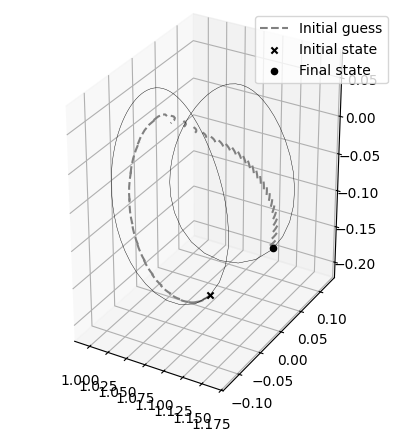

In [9]:
# quick check of what these look like
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1,projection='3d')
for idx,(_ts, _ys) in enumerate(sols_ig):
    if idx == 0:
        ax.plot(_ys[:,0], _ys[:,1], _ys[:,2], '--', color='grey', label='Initial guess')
    else:
        ax.plot(_ys[:,0], _ys[:,1], _ys[:,2], '--', color='grey')
ax.scatter(x0[0], x0[1], x0[2], marker='x', color='k', label='Initial state')
ax.scatter(xf[0], xf[1], xf[2], marker='o', color='k', label='Final state')
ax.plot(sol_lpo0.y[0,:], sol_lpo0.y[1,:], sol_lpo0.y[2,:], 'k-', lw=0.3)
ax.plot(sol_lpo1.y[0,:], sol_lpo1.y[1,:], sol_lpo1.y[2,:], 'k-', lw=0.3)
ax.set_aspect('equal')
ax.legend()
plt.show()

Clearly, the initial guess isn't a feasible trajectory! 
Let's now solve the problem with SCvxStar...

In [ ]:
# setup algorithm & solve
tol_feas = 1e-8
tol_opt = 1e-6
algo = scocp.SCvxStar(problem, tol_opt=tol_opt, tol_feas=tol_feas)
xopt, uopt, gopt, sols, summary_dict = algo.solve(
    xbar,
    ubar,
    gbar,
    maxiter = 250,
    verbose = True
)
assert summary_dict["status"] == "Optimal"
assert summary_dict["chi"][-1] <= tol_feas


|  Iter  |     J0      |   Delta J   |   Delta L   |    chi     |     rho     |     r      |   weight   | step acpt. |
     1   |  5.9315e-01 |  2.3373e+01 |  2.4351e+01 | 2.1758e-01 |  9.5984e-01 | 1.0000e-01 | 1.0000e+01 |    yes     |
     2   |  2.9315e-01 |  3.1696e+00 |  4.7001e+00 | 1.8644e-01 |  6.7438e-01 | 3.0000e-01 | 2.0000e+01 |    yes     |
     3   | -6.8528e-03 | -1.2302e+01 |  8.0430e+00 | 7.1092e-01 | -1.5296e+00 | 3.0000e-01 | 4.0000e+01 |    no      |
     4   |  1.4315e-01 |  3.5651e+00 |  7.8929e+00 | 2.7995e-01 |  4.5168e-01 | 1.5000e-01 | 4.0000e+01 |    yes     |
     5   |  3.7512e-02 |  1.1352e+01 |  1.8357e+01 | 2.8518e-01 |  6.1836e-01 | 1.5000e-01 | 8.0000e+01 |    yes     |
     6   |  2.1215e-03 | -1.3111e+01 |  4.0757e+01 | 4.8754e-01 | -3.2169e-01 | 1.5000e-01 | 1.6000e+02 |    no      |
     7   |  7.7597e-02 | -3.4189e+01 |  4.0597e+01 | 6.5424e-01 | -8.4217e-01 | 7.5000e-02 | 1.6000e+02 |    no      |
     8   |  7.5012e-02 | -2.8784e+01 |  3.9663e

In [ ]:
print(f"Initial guess TOF: {tf_guess:1.4f} --> Optimized TOF: {xopt[-1,7]:1.4f} (bounds: {tf_bounds[0]:1.4f} ~ {tf_bounds[1]:1.4f})")

It seems like we solved the problem! Let's check...

In [75]:
# evaluate nonlinear violations
geq_nl_opt, sols = problem.evaluate_nonlinear_dynamics(xopt, uopt, gopt, steps=20)
assert np.max(np.abs(geq_nl_opt)) <= tol_feas

In [ ]:
# plot results
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(2,3,1,projection='3d')
for (_ts, _ys) in sols_ig:
    ax.plot(_ys[:,0], _ys[:,1], _ys[:,2], '--', color='grey')
for (_ts, _ys) in sols:
    ax.plot(_ys[:,0], _ys[:,1], _ys[:,2], 'b-')

    # interpolate control
    _us_zoh = scocp.zoh_controls(taus, uopt, _ts)
    ax.quiver(_ys[:,0], _ys[:,1], _ys[:,2], _us_zoh[:,0], _us_zoh[:,1], _us_zoh[:,2], color='r', length=0.1)

ax.scatter(x0[0], x0[1], x0[2], marker='x', color='k', label='Initial state')
ax.scatter(xf[0], xf[1], xf[2], marker='o', color='k', label='Final state')
ax.plot(sol_lpo0.y[0,:], sol_lpo0.y[1,:], sol_lpo0.y[2,:], 'k-', lw=0.3)
ax.plot(sol_lpo1.y[0,:], sol_lpo1.y[1,:], sol_lpo1.y[2,:], 'k-', lw=0.3)
ax.set_aspect('equal')
ax.legend()

ax_m = fig.add_subplot(2,3,2)
ax_m.grid(True, alpha=0.5)
for (_ts, _ys) in sols:
    ax_m.plot(_ys[:,7], np.exp(_ys[:,6]), 'b-')
ax_m.axhline(np.exp(sols[-1][1][-1,6]), color='r', linestyle='--')
ax_m.text(0.0, 0.01 + np.exp(sols[-1][1][-1,6]), f"m_f = {np.exp(sols[-1][1][-1,6]):1.4f}", color='r')
ax_m.set(xlabel="Time", ylabel="Mass")
ax_m.legend()

ax_u = fig.add_subplot(2,3,3)
ax_u.grid(True, alpha=0.5)
ax_u.step(xopt[:,7], np.concatenate((gopt[:,0], [0.0])), label="Control", where='post', color='k')
for idx, (_ts, _ys) in enumerate(sols):
    ax_u.plot(_ys[:,7], Tmax/np.exp(_ys[:,6]), color='r', linestyle=':', label="Max accel." if idx == 0 else None)
ax_u.set(xlabel="Time", ylabel="Acceleration")
ax_u.legend()

ax_DeltaJ = fig.add_subplot(2,3,4)
ax_DeltaJ.grid(True, alpha=0.5)
ax_DeltaJ.plot(np.abs(summary_dict["DeltaJ"]), marker="o", color="k", ms=3)
ax_DeltaJ.axhline(tol_opt, color='r', linestyle='--', label='tol_opt')
ax_DeltaJ.set(yscale='log', xlabel='Iter.', ylabel='|DeltaJ|')
ax_DeltaJ.legend()

ax_DeltaL = fig.add_subplot(2,3,5)
ax_DeltaL.grid(True, alpha=0.5)
ax_DeltaL.plot(summary_dict["chi"], marker="o", color="k", ms=3)
ax_DeltaL.axhline(tol_feas, color='r', linestyle='--', label='tol_feas')
ax_DeltaL.set(yscale='log', xlabel='Iter.', ylabel='chi')
ax_DeltaL.legend()

ax = fig.add_subplot(2,3,6)
for (_ts, _ys) in sols_ig:
    ax.plot(_ts, _ys[:,7], '--', color='grey')
for (_ts, _ys) in sols:
    ax.plot(_ts, _ys[:,7], marker="o", ms=2, color='k')
ax.grid(True, alpha=0.5)
ax.set(xlabel="tau", ylabel="time")

plt.tight_layout()